In [1]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os
import analysis_methods as am

In [2]:
import PF
import ROI
importlib.reload(PF)
importlib.reload(ROI)

C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'ROI' from 'C:\\Users\\benhu\\Desktop\\Research\\radwatch-analysis\\ROI.py'>

In [3]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx
        
def plot_peak_region(roi, spectrum, source_energies, key):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    spec = spectrum
    counts = spec.counts_vals
    energies = spec.bin_centers_kev
    idx = f_near(energies,key) 
    roi_low = idx - 50
    roi_high = idx + 50

    plot_counts = counts[roi_low:roi_high]
    plot_energies = energies[roi_low:roi_high]
        
    roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.roi_pars["%s" %key])
    rlow = roi_low_bins[0][0]
    rhi = roi_high_bins[0][-1]
    plot_counts = counts[rlow:rhi]
    plot_energies = energies[rlow:rhi]

    rlow = roi_low_bins[0][0]
    rhi = roi_low_bins[0][-1]
    low_counts = counts[rlow:rhi]
    low_energies = energies[rlow:rhi]

    rlow = roi_high_bins[0][0]
    rhi = roi_high_bins[0][-1]
    high_counts = counts[rlow:rhi]
    high_energies = energies[rlow:rhi]

    rlow = roi_peak_bins[0][0]
    rhi = roi_peak_bins[0][-1]
    peak_counts = counts[rlow:rhi]
    peak_energies = energies[rlow:rhi]

    fig,ax = plt.subplots()
    ax.plot(plot_energies,plot_counts)
    ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
    ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
    ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
    ax.set_yscale('log')
    plt.title("%s Peak" %key)
        #plt.savefig('isotope %s.png'%isotope,dpi = 200)
        
def efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
    eff = []
    eff_uncer = []
    for count,A,br,sigma_c,sigma_A in zip (roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
        eff.append(count/spectrum.livetime/A/br)
        eff_uncer.append(m.sqrt((sigma_c/A)**2+(count*sigma_A/A**2)**2)/br/spectrum.livetime)
    return eff, eff_uncer

In [4]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)
        
        


In [5]:
spec = r'C:\Users\benhu\Desktop\Research\DataFiles\efficiency_calibration_2020-3-5.Spe'
bg = r'C:\Users\benhu\Desktop\Research\DataFiles\Background_Spectrum_12_20_19.Spe'
spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)

SpeFile: Reading file C:\Users\benhu\Desktop\Research\DataFiles\efficiency_calibration_2020-3-5.Spe


c:\users\benhu\desktop\research\becquerel\becquerel\parsers\spectrum_file.py:136: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


SpeFile: Reading file C:\Users\benhu\Desktop\Research\DataFiles\Background_Spectrum_12_20_19.Spe


In [6]:
# apply the kernel to the data to get SNR
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

c:\users\benhu\desktop\research\becquerel\becquerel\core\peakfinder.py:181: DeprecationWarning: channels is deprecated and will be removed in a future release. Use centroids instead.
  'release. Use centroids instead.', DeprecationWarning)


[506.5, 793.5, 914.5, 1345.5, 2111.5, 3881.5, 3950.5, 7107.5]


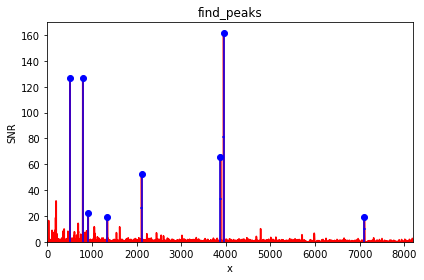

In [7]:
cal.peakfinder.find_peaks(min_snr=15, xmin=400)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()
#plt.savefig('find_peaks_spec',dpi = 200)

C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


found best gain: 0.369757 keV/channel
fit gain: 0.369756699383546 keV/channel
fit channels: [ 914.5 3881.5 3950.5 7107.5]


c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)


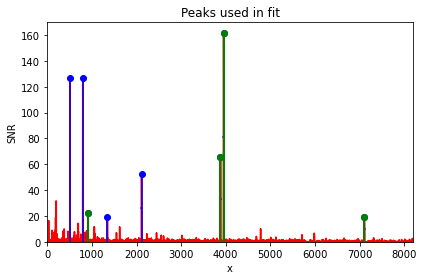

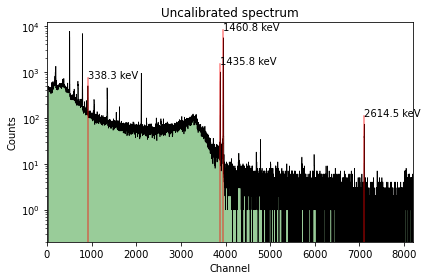

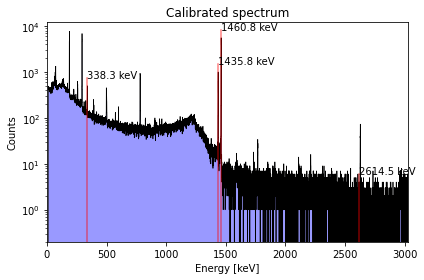

In [8]:
# perform calibration
cal.fit(
    [1435.795, 1460.82,2614.51],
    optional=[201.83,306.78, 351.93, 338.32,569.33,604.721,788.742,795.864, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.3, 10],
    de_max=100.,
)
plot_calibrator(cal)
spectrum = cal.peakfinder.spectrum


c:\users\benhu\desktop\research\becquerel\becquerel\core\peakfinder.py:181: DeprecationWarning: channels is deprecated and will be removed in a future release. Use centroids instead.
  'release. Use centroids instead.', DeprecationWarning)


[246.5, 539.5, 706.5, 1564.5, 1792.5, 1874.5, 2827.5, 4560.5, 5518.5]


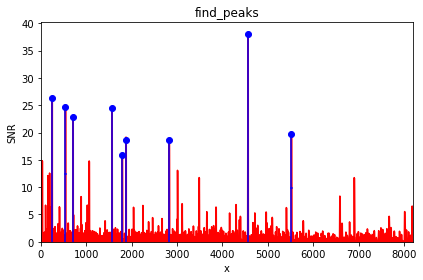

In [17]:
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(bg, kernel)
cal = bq.AutoCalibrator(finder)
cal.peakfinder.find_peaks(min_snr=15, xmin=200)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()
#plt.savefig('find peaks bg.png',dpi=200)

C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


found best gain: 0.320388 keV/channel
fit gain: 0.3203875656420919 keV/channel
fit channels: [2827.5 4560.5 5518.5]


c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)


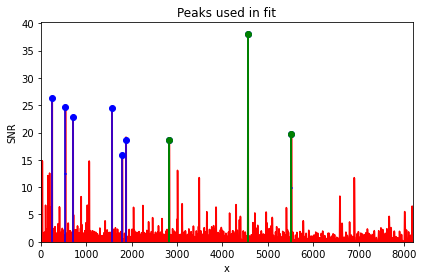

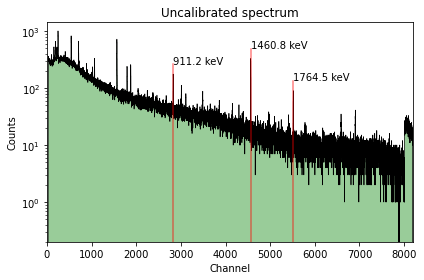

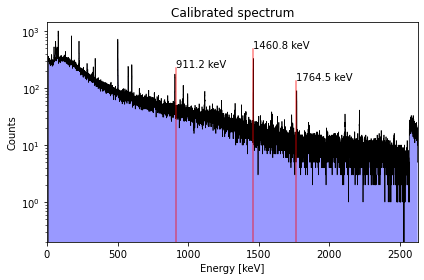

In [10]:
# perform calibration
cal.fit(
    [1460.82, 1764.49],
    optional=[186.21,238.63,609.32,911.20,242.00,295.22,338.32,351.93,1620.50],
    gain_range=[2.5e-2, 10],
    de_max=100.,
)
plot_calibrator(cal)
background = cal.peakfinder.spectrum

In [11]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                            'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([75,186,294,
                           782,1435.795,
                           1460]);
source_activities = np.array([16.259,16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L
branching_ratio = np.array([0.11,0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([1.6259,1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''

C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'The real source energies:\nLu-176: 88.34, 201.83, 306.78\nLa-138: 788.742,1435.795\nK-40: 1460.83'

In [12]:
#roi = ROI.ROI(spectrum, background, source_energies, sub_type = 0)
#delta_e = 8
#window = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
#roi.set_sideband(delta_e,window)
#roi.find_peak_energies()
#target_peaks = roi.target_peaks
#roi_result,roi_uncer = roi.get_counts()

roi = ROI.ROI(spectrum, background, source_energies, 0)
for i in range(len(source_energies.tolist())):
    roi.set_sideband(source_energies.tolist()[i], 8, [[-2, -1], [-0.5, 0.5], [1, 2]])
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result,roi_uncer = roi.get_counts()

#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result)
print('uncertainties:',roi_uncer)
#print('Lu_176 PF result:',pf_result)

background spec sidebands 2342.4901688969367
bg peak counts 2604.965464840419
signal bg 10667.0
signal peak 13526.000000000002
background spec sidebands 2150.5805705879266
bg peak counts 1724.4219553892226
signal bg 7042.0
signal peak 37622.00000000001
background spec sidebands 1123.958792219182
bg peak counts 1179.1018837727188
signal bg 3513.5
signal peak 33912.0
background spec sidebands 351.3735253345404
bg peak counts 353.5559695912768
signal bg 1141.0000000000002
signal peak 6009.999999999999
background spec sidebands 176.48699222807352
bg peak counts 147.2422391878074
signal bg 370.5
signal peak 6378.0
background spec sidebands 159.1729344579657
bg peak counts 151.60712770127998
signal bg 258.5
signal peak 34967.0
[  75.     186.     294.     782.    1435.795 1460.   ]
ROI result: [2596.5247040565196, 31006.15861519871, 30343.35690844646, 4866.817555743262, 6036.744753040266, 34716.065806756684]
uncertainties: [150.45168842285847, 209.62517081849498, 193.4162125569682, 84.319290

c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)
c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)
c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)
c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)
c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a fu

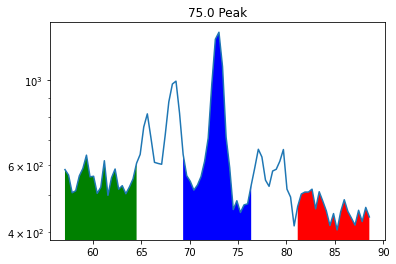

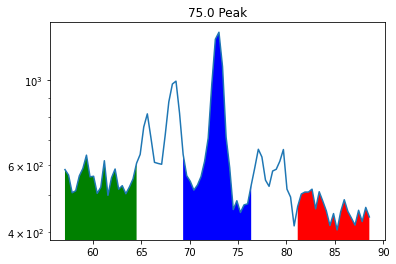

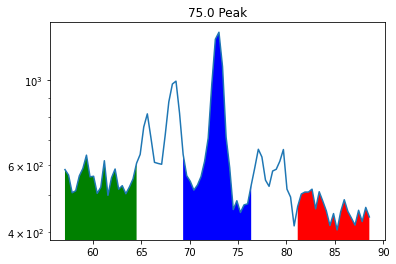

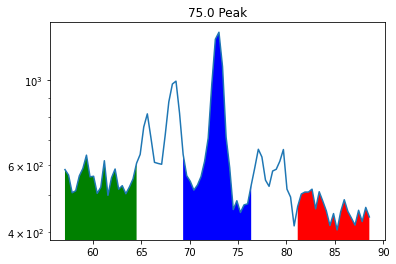

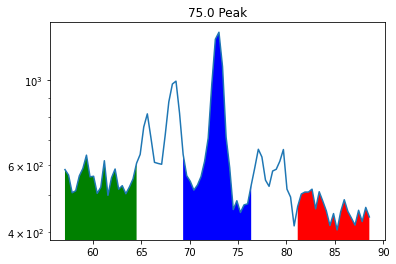

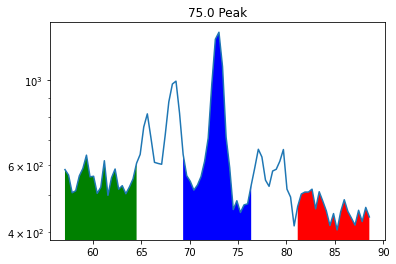

In [13]:
for i in range(len(source_energies.tolist())):
    plot_peak_region(roi, spectrum, source_energies, source_energies.tolist()[0])

In [14]:
eff,eff_uncer = efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer)
print(eff,eff_uncer)

[0.02016384945506886, 0.030798047584218818, 0.027574614165726347, 0.017070917627413595, 0.01090811217865924, 0.01032224571356943] [0.002330425276782594, 0.0030868352987196567, 0.002763057671264375, 0.0002977232991286779, 0.00015057977482501068, 5.957678706261503e-05]


C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


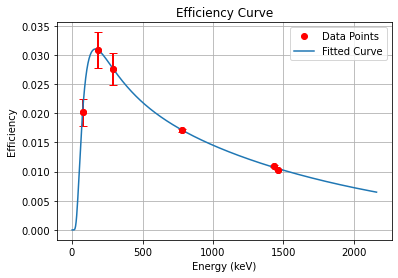

In [15]:
plot_eff = am.Efficiency(source_energies,eff,eff_uncer)

plot_eff.mutate()
plot_eff.fitting()
plot_eff.plotter()

In [16]:
plot_eff.save_fit('eff_calibration_test.txt')

C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
